## Activity 4 – Develop a 1D GAN from scratch

In this activity, we will:
*	Select a One Dimensional Function
*	Define a Discriminator Model
*	Define a Generator Model
*	Training the Generator Model
*	Evaluating the Performance of the GAN
*	Complete Example of Training the GAN



### Mount Google Drive

---



Mount your Google Drive on your runtime using an authorization code.

Follow the instruction on the screen to authorise Colab accessing your drive. On your Google Drive, you can access you files prepend with “/content/drive/MyDrive/”

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Replace the path below with the folder location of your choice.

In [ ]:
output_folder = '/content/drive/MyDrive/Crafting/DLP/Day 2'

### Select a One Dimensional Function:  

---



The first step is to select a one-dimensional function to model. Something of the form:  y=f(x).

Where x are input values and y are the output values of the function. Specifically, we want a function that we can easily understand and plot. This will help in both setting an expectation of what the model should be generating and in using a visual inspection of generated examples to get an idea of their quality. 

We will use a simple function of x2; that is, the function will return the square of the input. We can define the function in Python as follows:


In [ ]:
import math
# simple function
def calculate(x):
  return x * x

We can define the input domain as real values between -0.5 and 0.5 and calculate the output value for each input value in this linear range, then plot the results to get an idea of how inputs relate to outputs. The complete example is listed below.

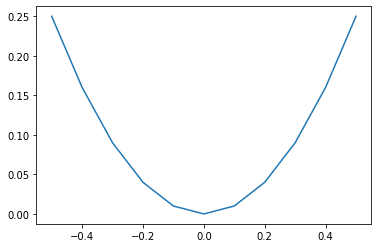

In [ ]:
# demonstrate simple x^2 function
from matplotlib import pyplot

# define inputs
inputs = [-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5]

# calculate outputs
outputs = [calculate(x) for x in inputs]

# plot the result
pyplot.plot(inputs, outputs)
pyplot.show()

Running the example calculates the output value for each input value and creates a plot of input vs. output values. We can see that values far from 0.0 result in larger output values, whereas values close to zero result in smaller output values, and that this behaviour is symmetrical around zero.

We can generate random samples or points from the function. This can be achieved by generating random values between -0.5 and 0.5 and calculating the associated output value. Repeating this many times will give a sample of points from the function, e.g. real samples. Plotting these samples using a scatter plot will show the same u-shape plot, although comprised of the individual random samples. The complete example is listed below.

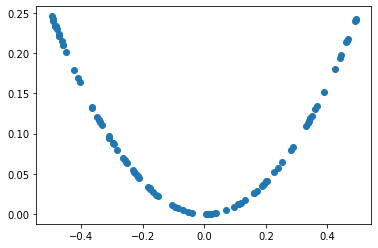

In [ ]:
# generate randoms sample from x^2
def generate_samples(n=100):
  # generate random inputs in [-0.5, 0.5]
  X = rand(n) - 0.5
  # generate outputs X^2 (quadratic)
  Y = X * X
  # stack arrays
  X = X.reshape(n, 1)
  Y = Y.reshape(n, 1)
  return hstack((X, Y))

# example of generating random samples from X^2
from numpy.random import rand
from numpy import hstack
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
from numpy import zeros
from numpy import ones
from numpy import hstack
from numpy.random import randn

# generate samples
data = generate_samples()
# plot samples
pyplot.scatter(data[:, 0], data[:, 1])
pyplot.show()  

Running the example generates 100 random inputs and their calculated output and plots the sample as a scatter plot, showing the familiar u-shape.

g)	We can use this function as a starting point for generating real samples for our discriminator function. Specifically, **a sample is comprised of a vector with two elements, one for the input and one for the output of our one-dimensional function**. We can also imagine how a generator model could generate new samples that we can plot and compare to the expected u-shape of the X2 function. Specifically, a generator would output a vector with two elements: one for the input and one for the output of our one-dimensional function.

### Define a Discriminator Model

The model must take a sample from our problem, such as a vector with two elements, and output a classification prediction as to whether the sample is real or fake.
-	**Inputs**: Sample with two real values.
-	**Outputs**: Binary classification, likelihood the sample is real (or fake).


b)	The problem is very simple, meaning that we don’t need a complex neural network to model it. The discriminator model will have one hidden layer with 25 nodes and we will use the ***ReLU*** activation function and an appropriate weight initialization method called ***He*** weight initialization. The output layer will have one node for the binary classification using the ***sigmoid*** activation function. 

The model will minimize the binary cross-entropy loss function, and the Adam version of stochastic gradient descent will be used because it is very effective. 

The **define_discriminator()** function below defines and returns the discriminator model. 

The function parameterizes the number of inputs to expect, which defaults to two.


In [ ]:
# define the standalone discriminator model
def define_discriminator(n_inputs=2):
  model = Sequential()
  model.add(Dense(25, activation="relu", kernel_initializer="he_uniform", input_dim=n_inputs))
  model.add(Dense(1, activation="sigmoid"))
  # compile model
  model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
  return model

Add the following code to create the discriminator model and summarizes it.

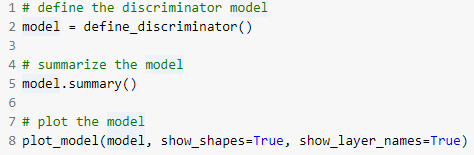

In [ ]:
#
#[ENTER YOUR CODE HERE]
#

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 25)                75        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


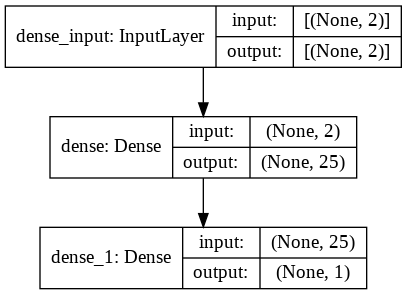

In [ ]:
# define the discriminator model
model = define_discriminator()

# summarize the model
model.summary()

# plot the model
plot_model(model, show_shapes=True, show_layer_names=True)

Running the code above defines the discriminator model and summarizes it.

We could start training this model now with real examples with a class label of one and randomly generated samples with a class label of zero. There is no need to do this, but the elements we will develop will be useful later, and it helps to see that the discriminator is just a normal neural network model. First, we can update our **generate_samples()** function from the prediction section and call it **generate_real_samples()** and have it also return the output class labels for the real samples, specifically, an array of 1 values, where class = 1 means real.

In [ ]:
# generate n real samples with class labels
def generate_real_samples(n):
  # generate inputs in [-0.5, 0.5]
  X1 = rand(n) - 0.5
  # generate outputs X^2
  X2 = X1 * X1
  # stack arrays
  X1 = X1.reshape(n, 1)
  X2 = X2.reshape(n, 1)
  X = hstack((X1, X2))
  # generate class labels
  y = ones((n, 1))
  return X, y

Next, we can create a copy of this function for creating fake examples. In this case, we will generate random values in the range -1 and 1 for both elements of a sample. The output class label for all of these examples is 0. This function will act as our fake generator model 

In [ ]:
# generate n fake samples with class labels
def generate_fake_samples(n):
  # generate inputs in [-1, 1]
  X1 = -1 + rand(n) * 2
  # generate outputs in [-1, 1]
  X2 = -1 + rand(n) * 2
  # stack arrays
  X1 = X1.reshape(n, 1)
  X2 = X2.reshape(n, 1)
  X = hstack((X1, X2))
  # generate class labels
  y = zeros((n, 1))
  return X, y

Next, we need a function to train and evaluate the discriminator model. This can be achieved by manually enumerating the training epochs and for each epoch generating a half batch of real examples and a half batch of fake examples, and updating the model on each, e.g. one whole batch of examples. The train() function could be used, but in this case, we will use the **train_on_batch()** function directly. The model can then be evaluated on the generated examples and we can report the classification accuracy on the real and fake samples. The **train_discriminator()** function below implements this, training the model for 1,000 batches and using 128 samples per batch (64 fake and 64 real). 

In [ ]:
def train_discriminator(model, n_epochs=1000, n_batch=128):
	half_batch = int(n_batch / 2)
	# run epochs manually
	for i in range(n_epochs):
		# generate real examples
		X_real, y_real = generate_real_samples(half_batch)
		# update model
		model.train_on_batch(X_real, y_real)
  
		# generate fake examples
		X_fake, y_fake = generate_fake_samples(half_batch)
		# update model
		model.train_on_batch(X_fake, y_fake)

		# evaluate the model
		_, acc_real = model.evaluate(X_real, y_real, verbose=0)
		_, acc_fake = model.evaluate(X_fake, y_fake, verbose=0)
		print(i, acc_real, acc_fake)

We can now create the discriminator model and traing it

In [ ]:
# define the discriminator model
model = define_discriminator()

In [ ]:
# fit the model
train_discriminator(model)

0 0.5 0.59375
1 0.46875 0.515625
2 0.5 0.546875
3 0.53125 0.625
4 0.53125 0.65625
5 0.46875 0.703125
6 0.59375 0.65625
7 0.53125 0.59375
8 0.453125 0.625
9 0.515625 0.625
10 0.671875 0.625
11 0.671875 0.671875
12 0.46875 0.703125
13 0.328125 0.71875
14 0.53125 0.65625
15 0.5 0.65625
16 0.5 0.609375
17 0.34375 0.65625
18 0.453125 0.53125
19 0.375 0.71875
20 0.28125 0.71875
21 0.25 0.59375
22 0.40625 0.6875
23 0.328125 0.71875
24 0.375 0.6875
25 0.234375 0.765625
26 0.3125 0.75
27 0.234375 0.671875
28 0.203125 0.734375
29 0.28125 0.703125
30 0.28125 0.625
31 0.234375 0.734375
32 0.1875 0.65625
33 0.1875 0.78125
34 0.25 0.75
35 0.1875 0.65625
36 0.234375 0.734375
37 0.15625 0.65625
38 0.234375 0.609375
39 0.078125 0.703125
40 0.171875 0.6875
41 0.078125 0.859375
42 0.0625 0.75
43 0.0625 0.640625
44 0.125 0.84375
45 0.078125 0.71875
46 0.078125 0.734375
47 0.046875 0.78125
48 0.09375 0.75
49 0.03125 0.71875
50 0.046875 0.8125
51 0.140625 0.828125
52 0.078125 0.734375
53 0.078125 0.828125
5

Running the example generates real and fake examples and updates the model, then evaluates the model on the same examples and prints the classification accuracy. 

**Note**: Your specific results may vary given the stochastic nature of the learning algorithm. Consider running the example a few times and compare the average performance. 

In this case, the model rapidly learns to correctly identify the real examples with perfect accuracy and is very good at identifying the fake examples with 80% to 90% accuracy. 

Training the discriminator model is straightforward. The goal is to train a generator model, not a discriminator model, and that is where the complexity of GANs truly lies. 

### Define a Generator Model

The generator model takes as input a point from the latent space and generates a new sample, e.g. a vector with both the input and output elements of our function, e.g. x and x2. A latent variable is a hidden or unobserved variable, and a latent space is a multi-dimensional vector space of these variables. We can define the size of the latent space for our problem and the shape or distribution of variables in the latent space 

After training, points in the latent space will correspond to points in the output space, e.g. in the space of generated samples. We will define a small latent space of five dimensions and use the standard approach in the GAN literature of using a Gaussian distribution for each variable in the latent space. We will generate new inputs by drawing random numbers from a standard Gaussian distribution, i.e. mean of zero and a standard deviation of one.

*	**Inputs**: Point in latent space, e.g. a five-element vector of Gaussian random numbers. 
*	**Outputs**: Two-element vector representing a generated sample for our function (x and x2).


The generator model will be small like the discriminator model. It will have a single ***Dense*** hidden layer with fifteen nodes and will use the ***ReLU*** activation function and ***He*** weight initialization. The output layer will have two nodes for the two elements in a generated vector and will use a linear activation function. A linear activation function is used because we know we want the generator to output a vector of real values and the scale will be [-0.5, 0.5] for the first element and about [0.0, 0.25] for the second element.

**The model is not compiled**. The reason for this is that the generator model is not fit directly. The define_generator() function below defines and returns the generator model. The size of the latent dimension is parameterized in case we want to play with it later, and the output shape of the model is also parameterized, matching the function for defining the discriminator model.


In [ ]:
# define the standalone generator model
def define_generator(latent_dim, n_outputs=2):
  model = Sequential()
  model.add(Dense(15, activation="relu", kernel_initializer="he_uniform", input_dim=latent_dim))
  model.add(Dense(n_outputs, activation="linear"))
  return model

We can now create the generator and plot it

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 15)                90        
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 32        
Total params: 122
Trainable params: 122
Non-trainable params: 0
_________________________________________________________________


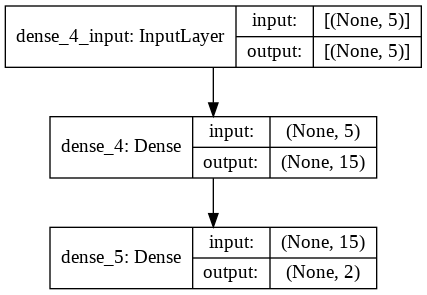

In [ ]:
# define the discriminator model
model = define_generator(5)

# summarize the model
model.summary()

# plot the model
plot_model(model, show_shapes = True, show_layer_names = True)

This model cannot do much at the moment. Nevertheless, we can demonstrate how to use it to generate samples. This is not needed, but again, some of these elements may be useful later. 

The first step is to generate new random points in the latent space. We can achieve this by calling the randn() NumPy function for generating arrays of random numbers drawn from a standard Gaussian.  The array of random numbers can then be reshaped into samples: that is n rows with five elements per row. The **generate_latent_points()** function below implements this and generates the desired number of points in the latent space that can be used as input to the generator model. 


In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
  # generate points in the latent space
  x_input = randn(latent_dim * n)
  # reshape into a batch of inputs for the network
  x_input = x_input.reshape(n, latent_dim)
  return x_input

Next, we can use the generated points as input the generator model to generate new samples, then plot the samples. The **generate_fake_samples()** function below implements this, where the defined generator and size of the latent space are passed as arguments, along with the number of points for the model to generate. 

In [ ]:
# use the generator to generate n fake examples and plot the results
def generate_fake_samples(generator, latent_dim, n):
  # generate points in latent space
  x_input = generate_latent_points(latent_dim, n)
  # predict outputs
  X = generator.predict(x_input)
  # plot the results
  pyplot.scatter(X[:, 0], X[:, 1])
  pyplot.show()

We can now define the latent space, create the generator model and generate some fake samples as follows

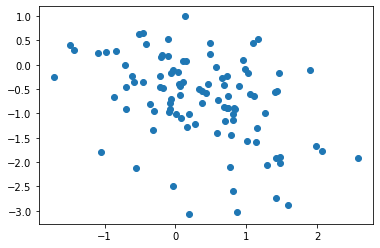

In [ ]:
# size of the latent space
latent_dim = 5

# define the discriminator model
model = define_generator(latent_dim)

# generate and plot generated samples
generate_fake_samples(model, latent_dim, 100)

Running the example generates 100 random points from the latent space, uses this as input to the generator and generates 100 fake samples from our one-dimensional function domain. As the generator has not been trained, the generated points are complete rubbish, as we expect, but we can imagine that as the model is trained, these points will slowly begin to resemble the target function and its u-shape. 



### Training the Generator Model

The weights in the generator model are updated based on the performance of the discriminator model. When the discriminator is good at detecting fake samples, the generator is updated more (via a larger error gradient), and when the discriminator model is relatively poor or confused when detecting fake samples, the generator model is updated less.

There may be many ways to implement this using the Keras API, but perhaps the simplest approach is to create a new model that subsumes or encapsulates the generator and discriminator models. Specifically, a new GAN model can be defined that stacks the generator and discriminator such that the generator receives as input random points in the latent space, generates samples that are fed into the discriminator model directly, classified, and the output of this larger model can be used to update the model weights of the generator.  To be clear, we are not talking about a new third model, just a logical third model that uses the already-defined layers and weights from the standalone generator and discriminator models.

Only the discriminator is concerned with distinguishing between real and fake examples; therefore, the discriminator model can be trained in a standalone manner on examples of each. 

The generator model is only concerned with the discriminator’s performance on fake examples. Therefore, we will mark all of the layers in the discriminator as not trainable when it is part of the GAN model so that they cannot be updated and overtrained on fake examples.

When training the generator via this subsumed GAN model, there is one more important change. The generator wants the discriminator to think that the samples output by the generator are real, not fake. Therefore, when the generator is trained as part of the GAN model, we will mark the generated samples as real (class = 1). We can imagine that the discriminator will then classify the generated samples as not real (class = 0) or a low probability of being real (0.3 or 0.5).

The backpropagation process used to update the model weights will see this as a large error and will update the model weights (i.e. only the weights in the generator) to correct for this error, in turn making the generator better at generating plausible fake samples.
-	**Inputs**: Point in latent space, e.g. a five-element vector of Gaussian random numbers. 
-	**Outputs**: Binary classification, likelihood the sample is real (or fake).


The **define_gan()** function below takes as arguments the already-defined generator and discriminator models and creates the new logical third model subsuming these two models. The weights in the discriminator are marked as not trainable, which only affects the weights as seen by the GAN model and not the standalone discriminator model. The GAN model then uses the same binary cross-entropy loss function as the discriminator and the efficient Adam version of stochastic gradient descent.

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
  # make weights in the discriminator not trainable
  discriminator.trainable = False
  # connect them
  model = Sequential()
  # add generator
  model.add(generator)
  # add the discriminator
  model.add(discriminator)
  # compile model
  model.compile(loss="binary_crossentropy", optimizer="adam")
  return model

Note:  Making the discriminator not trainable is a clever trick in the Keras API. The trainable property impacts the model when it is compiled. The discriminator model was compiled with trainable layers, therefore the model weights in those layers will be updated when the standalone model is updated via calls to *train_on_batch()*. The discriminator model was marked as not trainable, added to the GAN model, and compiled. In this model, the model weights of the discriminator model are not trainable and cannot be changed when the GAN model is updated via calls to *train_on_batch()*.

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_5 (Sequential)    (None, 2)                 122       
_________________________________________________________________
sequential_4 (Sequential)    (None, 1)                 101       
Total params: 223
Trainable params: 122
Non-trainable params: 101
_________________________________________________________________


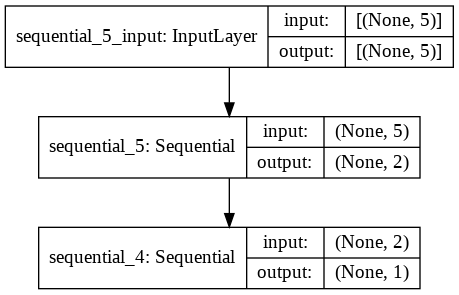

In [ ]:
# size of the latent space
latent_dim = 5

# create the discriminator
discriminator = define_discriminator()

# create the generator
generator = define_generator(latent_dim)

# create the gan
gan_model = define_gan(generator, discriminator)

# summarize gan model
gan_model.summary()

# plot gan model
plot_model(gan_model, show_shapes=True, show_layer_names=True)

Training the composite model involves generating a batch-worth of points in the latent space via the **generate_latent_points()** function in the previous section, and class = 1 labels and calling the **train_on_batch()** function. The **train_gan()** function below demonstrates this, although it is pretty uninteresting as only the generator will be updated each epoch, leaving the discriminator with default model weights.



```
# train the composite model
def train_gan(gan_model, latent_dim, n_epochs=10000, n_batch=128):
  # manually enumerate epochs
  for i in range(n_epochs):
    # prepare points in latent space as input for the generator
    x_gan = generate_latent_points(latent_dim, n_batch)
    # create inverted labels for the fake samples
    y_gan = ones((n_batch, 1))
    # update the generator via the discriminator’s error 
    gan_model.train_on_batch(x_gan, y_gan)           

```



**Instead, what is required is that we first update the discriminator model with real and fake samples, then update the generator via the composite model**. This requires combining elements from the ***train_discriminator()*** function defined in the discriminator section and the ***train_gan()*** function defined above. It also requires that the ***generate_fake_samples()*** function use the generator model to generate fake samples instead of generating random numbers. The complete train function for updating the discriminator model and the generator (via the composite model) is listed below.

In [ ]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=128,
    n_eval=2000):
  # determine half the size of one batch, for updating the discriminator
  half_batch = int(n_batch / 2)
  # manually enumerate epochs
  for i in range(n_epochs):
    # prepare real samples
    x_real, y_real = generate_real_samples(half_batch)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
    # update discriminator
    d_model.train_on_batch(x_real, y_real)
    d_model.train_on_batch(x_fake, y_fake)
    # prepare points in latent space as input for the generator
    x_gan = generate_latent_points(latent_dim, n_batch)
    # create inverted labels for the fake samples
    y_gan = ones((n_batch, 1))
    # update the generator via the discriminator"s error
    gan_model.train_on_batch(x_gan, y_gan)
    # evaluate the model every n_eval epochs
    if (i+1) % n_eval == 0:
      summarize_performance(i, g_model, d_model, latent_dim)

### Evaluating the Performance of the GAN

Generally, **there are no objective ways to evaluate the performance of a GAN model**.

In this specific case, we can devise an objective measure for the generated samples as we know the true underlying input domain and target function and can calculate an objective error measure. Nevertheless, we will not calculate this objective error score in this tutorial. Instead, we will use the subjective approach used in most GAN applications. Specifically, we will use the generator to generate new samples and inspect them relative to real samples from the domain.

First, we can use the **generate_real_samples()** function developed in the discriminator part above to generate real examples. Creating a scatter plot of these examples will create the familiar u-shape of our target function


In [ ]:
# generate n real samples with class labels
def generate_real_samples(n):
	# generate inputs in [-0.5, 0.5]
	X1 = rand(n) - 0.5
	# generate outputs X^2
	X2 = X1 * X1
	# stack arrays
	X1 = X1.reshape(n, 1)
	X2 = X2.reshape(n, 1)
	X = hstack((X1, X2))
	# generate class labels
	y = ones((n, 1))
	return X, y

d)	Next, we can use the generator model to generate the same number of fake samples. This requires first generating the same number of points in the latent space via the **generate_latent_points()** function developed in the generator section above. These can then be passed to the generator model and used to generate samples that can also be plotted on the same scatter plot.

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
  # generate points in the latent space
  x_input = randn(latent_dim * n)
  # reshape into a batch of inputs for the network
  x_input = x_input.reshape(n, latent_dim)
  return x_input

The **generate_fake_samples()** function below generates these fake samples and the associated class label of 0 which will be useful later.

In [ ]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
  # generate points in latent space
  x_input = generate_latent_points(latent_dim, n)
  # predict outputs
  X = generator.predict(x_input)
  # create class labels
  y = zeros((n, 1))
  return X, y

Having both samples plotted on the same graph allows them to be directly compared to see if the same input and output domain are covered and whether the expected shape of the target function has been appropriately captured, at least subjectively. The **summarize_performance()** function below can be called any time during training to create a scatter plot of real and generated points to get an idea of the current capability of the generator model.

In [ ]:
# plot real and fake points
def summarize_performance(generator, latent_dim, n=100):
  # prepare real samples
  x_real, y_real = generate_real_samples(n)
  # prepare fake examples
  x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
  # scatter plot real and fake data points
  pyplot.scatter(x_real[:, 0], x_real[:, 1], color="red") 
  pyplot.scatter(x_fake[:, 0], x_fake[:, 1], color="blue") 
  pyplot.show()


We may also be interested in the performance of the discriminator model at the same time. Specifically, we are interested to know how well the discriminator model can correctly identify real and fake samples. A good generator model should make the discriminator model confused, resulting in a classification accuracy closer to 50% on real and fake examples. We can update the **summarize_ performance()** function to also take the discriminator and current epoch number as arguments and report the accuracy on the sample of real and fake examples. It will also generate a plot of synthetic plots and save it to file for later review

In [ ]:
# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
  # prepare real samples
  x_real, y_real = generate_real_samples(n)
  # evaluate discriminator on real examples
  _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
  # prepare fake examples
  x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
  # evaluate discriminator on fake examples
  _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
  # summarize discriminator performance
  print(epoch, acc_real, acc_fake)
  # scatter plot real and fake data points
  pyplot.scatter(x_real[:, 0], x_real[:, 1], color="red")
  pyplot.scatter(x_fake[:, 0], x_fake[:, 1], color="blue")
  # save plot to file
  filename = output_folder + "/generated_plot_e%03d.png" % (epoch + 1)
  pyplot.savefig(filename)
  pyplot.close()

This function can then be called periodically during training. For example, if we choose to train the models for 10,000 iterations, it may be interesting to check-in on the performance of the model every 2,000 iterations. We can achieve this by parameterizing the frequency of the check-in via n eval argument, and calling the **summarize_performance()** function from the train() function after the appropriate number of iterations. The updated version of the train() function with this change is listed below.

In [ ]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=128,
    n_eval=2000):
  # determine half the size of one batch, for updating the discriminator
  half_batch = int(n_batch / 2)
  # manually enumerate epochs
  for i in range(n_epochs):
    # prepare real samples
    x_real, y_real = generate_real_samples(half_batch)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
    # update discriminator
    d_model.train_on_batch(x_real, y_real)
    d_model.train_on_batch(x_fake, y_fake)
    # prepare points in latent space as input for the generator
    x_gan = generate_latent_points(latent_dim, n_batch)
    # create inverted labels for the fake samples
    y_gan = ones((n_batch, 1))
    # update the generator via the discriminator"s error
    gan_model.train_on_batch(x_gan, y_gan)
    # evaluate the model every n_eval epochs
    if (i+1) % n_eval == 0:
      summarize_performance(i, g_model, d_model, latent_dim)

We now have everything we need to train and evaluate a GAN on our chosen one-dimensional function. 

In [ ]:
# size of the latent space
latent_dim = 5

# create the discriminator
discriminator = define_discriminator()

# create the generator
generator = define_generator(latent_dim)

# create the gan
gan_model = define_gan(generator, discriminator)

# train model
train(generator, discriminator, gan_model, latent_dim)

1999 0.4300000071525574 0.5799999833106995
3999 0.23999999463558197 0.8799999952316284
5999 0.44999998807907104 0.49000000953674316
7999 0.6399999856948853 0.44999998807907104
9999 0.47999998927116394 0.5899999737739563


We can see that the training process is relatively unstable. The first column reports the iteration number, the second the classification accuracy of the discriminator for real examples, and the third column the classification accuracy of the discriminator for generated (fake) examples. In this case, we can see that the discriminator remains relatively confused about real examples, and performance on identifying fake examples varies.

We will omit providing the five created plots here for brevity; instead we will look at only two. The first plot is created after 2,000 iterations and shows real (red) vs. fake (blue) samples. The model performs poorly initially with a cluster of generated points only in the positive input domain, although with the right functional relationship

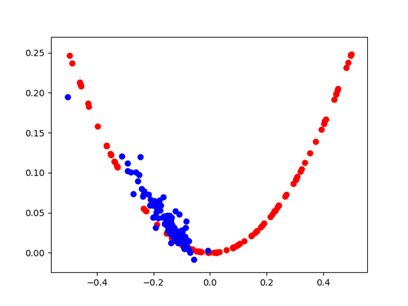

The second plot shows real (red) vs. fake (blue) after 10,000 iterations. Here we can see that the generator model does a reasonable job of generating plausible samples, with the input values in the right domain between [-0.5 and 0.5] and the output values showing the X2 relationship, or close to it.

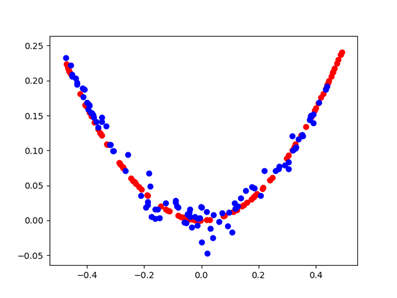